<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/simclr-refactor/feature_eval/mini_batch_logistic_regression_evaluator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision

In [2]:
!pip install gdown

In [3]:
def get_file_id_by_model(folder_name):
  file_id = {'resnet18_100-epochs_stl10': '14_nH2FkyKbt61cieQDiSbBVNP8-gtwgF',
             'resnet18_100-epochs_cifar10': '1lc2aoVtrAetGn0PnTkOyFzPCIucOJq7C',
             'resnet50_50-epochs_stl10': '1ByTKAUsdm_X7tLcii6oAEl5qFRqRMZSu'}
  return file_id.get(folder_name, "Model not found.")

In [4]:
folder_name = 'resnet18_100-epochs_cifar10'
file_id = get_file_id_by_model(folder_name)
print(folder_name, file_id)

resnet18_100-epochs_cifar10 1lc2aoVtrAetGn0PnTkOyFzPCIucOJq7C


In [5]:
# download and extract model files
os.system('gdown https://drive.google.com/uc?id={}'.format(file_id))
os.system('unzip {}'.format(folder_name))
!ls

 1ch_stl_400epochs_perp100_iter500.png
 1ch_stl_400epochs_perp30_iter500.png
 1ch_stl_400epochs_perp50_iter500.png
 1ch_stl_400epochs_perp75_iter1000.png
 1ch_stl_400epochs_perp75_iter500.png
'Adapting MoCo.ipynb'
 ATM_SimCLR.ipynb
 checkpoint_0040.pth.tar
 checkpoint_0100.pth.tar
 cifar10
 config.yml
 data
 datasets
 events.out.tfevents.1610901418.4cb2c837708d.2683796.0
 events.out.tfevents.1610927742.4cb2c837708d.2694093.0
 Feature_vector1.ipynb
 feature_vector_plots_cat0.png
 feature_vector_plots_cat1.png
 feature_vector_plots_cat2.png
 feature_vector_plots_cat3.png
 feature_vector_plots_cat4.png
 feature_vector_plots_cat5.png
 feature_vector_plots_cat6.png
 feature_vector_plots_cat7.png
 feature_vector_plots_cat8.png
 feature_vector_plots_cat9.png
 Image_Folder.ipynb
 InfoNCELoss.ipynb
 Loader.ipynb
 Logging.ipynb
 logs
 mini_batch_logistic_regression_evaluator.ipynb
 module1.log
 resnet18_100-epochs_cifar10.zip
 resnet50_50-epochs_stl10.zip
 ResNet50_fine.ipynb
 resnet_ch3
 ResNet

In [6]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [8]:
def get_stl10_data_loaders(download, shuffle=False, batch_size=256):
  train_dataset = datasets.STL10('./data', split='train', download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = datasets.STL10('./data', split='test', download=download,
                                  transform=transforms.ToTensor())

  test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
  return train_loader, test_loader

def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
  train_dataset = datasets.CIFAR10('./data', train=True, download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = datasets.CIFAR10('./data', train=False, download=download,
                                  transform=transforms.ToTensor())

  test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
  return train_loader, test_loader

In [21]:
model = torchvision.models.resnet50(pretrained=False, num_classes=10).to(device)
#model = torchvision.models.resnet18(pretrained=False, num_classes=10).to(device)

In [11]:
checkpoint = torch.load('checkpoint_0040.pth.tar', map_location=device)
state_dict = checkpoint['state_dict']

for k in list(state_dict.keys()):

  if k.startswith('backbone.'):
    if k.startswith('backbone') and not k.startswith('backbone.fc'):
      # remove prefix
      state_dict[k[len("backbone."):]] = state_dict[k]
  del state_dict[k]

In [12]:
log = model.load_state_dict(state_dict, strict=False)
assert log.missing_keys == ['fc.weight', 'fc.bias']

In [16]:
train_loader, test_loader = get_cifar10_data_loaders(download=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
if config.dataset_name == 'cifar10':
  train_loader, test_loader = get_cifar10_data_loaders(download=True)
elif config.dataset_name == 'stl10':
  train_loader, test_loader = get_stl10_data_loaders(download=True)
print("Dataset:", config.dataset_name)

NameError: name 'config' is not defined

In [14]:
# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

마지막 fc만 train하는 의미는? 

In [13]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## 1. Plain training, R50

In [24]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(device)
for epoch in range(epochs):
  top1_train_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    top1 = accuracy(logits, y_batch, topk=(1,))
    top1_train_accuracy += top1[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  top1_train_accuracy /= (counter + 1)
  top1_accuracy = 0
  top5_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
  
    top1, top5 = accuracy(logits, y_batch, topk=(1,5))
    top1_accuracy += top1[0]
    top5_accuracy += top5[0]
  
  top1_accuracy /= (counter + 1)
  top5_accuracy /= (counter + 1)
  print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

Epoch 0	Top1 Train accuracy 81.823974609375	Top1 Test accuracy: 65.263671875	Top5 test acc: 96.39820861816406
Epoch 1	Top1 Train accuracy 84.09996795654297	Top1 Test accuracy: 66.9312973022461	Top5 test acc: 96.38959503173828
Epoch 2	Top1 Train accuracy 85.9948959350586	Top1 Test accuracy: 67.10305786132812	Top5 test acc: 96.63603210449219
Epoch 3	Top1 Train accuracy 87.03643035888672	Top1 Test accuracy: 67.45577239990234	Top5 test acc: 96.56824493408203
Epoch 4	Top1 Train accuracy 87.81847381591797	Top1 Test accuracy: 67.38683319091797	Top5 test acc: 96.46427154541016
Epoch 5	Top1 Train accuracy 89.07166290283203	Top1 Test accuracy: 67.46553802490234	Top5 test acc: 96.58145904541016
Epoch 6	Top1 Train accuracy 89.69746398925781	Top1 Test accuracy: 68.31456756591797	Top5 test acc: 96.34249114990234
Epoch 7	Top1 Train accuracy 90.21244812011719	Top1 Test accuracy: 69.1331558227539	Top5 test acc: 96.49816131591797
Epoch 8	Top1 Train accuracy 91.0487060546875	Top1 Test accuracy: 69.327323

 lr = 3e-4일 때 66%까지였음

## Plain, R18

In [17]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(device)
for epoch in range(epochs):
  top1_train_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    top1 = accuracy(logits, y_batch, topk=(1,))
    top1_train_accuracy += top1[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  top1_train_accuracy /= (counter + 1)
  top1_accuracy = 0
  top5_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
  
    top1, top5 = accuracy(logits, y_batch, topk=(1,5))
    top1_accuracy += top1[0]
    top5_accuracy += top5[0]
  
  top1_accuracy /= (counter + 1)
  top5_accuracy /= (counter + 1)
  print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

/home/hoseung/anaconda3/envs/tm39/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0	Top1 Train accuracy 47.351322174072266	Top1 Test accuracy: 55.680145263671875	Top5 test acc: 95.07008361816406
Epoch 1	Top1 Train accuracy 61.62627410888672	Top1 Test accuracy: 61.480926513671875	Top5 test acc: 96.21266174316406
Epoch 2	Top1 Train accuracy 70.23516845703125	Top1 Test accuracy: 61.81928253173828	Top5 test acc: 96.62798309326172
Epoch 3	Top1 Train accuracy 76.32772827148438	Top1 Test accuracy: 63.0158576965332	Top5 test acc: 96.03343963623047
Epoch 4	Top1 Train accuracy 79.60857391357422	Top1 Test accuracy: 62.2478141784668	Top5 test acc: 95.7496566772461
Epoch 5	Top1 Train accuracy 82.0643310546875	Top1 Test accuracy: 62.3127326965332	Top5 test acc: 95.70944213867188
Epoch 6	Top1 Train accuracy 85.04544067382812	Top1 Test accuracy: 62.02895736694336	Top5 test acc: 95.69853210449219
Epoch 7	Top1 Train accuracy 87.61878204345703	Top1 Test accuracy: 63.8591423034668	Top5 test acc: 95.95645904541016
Epoch 8	Top1 Train accuracy 89.85172271728516	Top1 Test accuracy: 6

# feature embedding distribution by t-SNE 

마지막 fc를 Identity로 변환

In [18]:
import torch.nn as nn
model.fc = nn.Identity()

In [38]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
feature_arr = []
label_arr = []
for images, l in test_loader:
    images = images.to(device)

    #with autocast(enabled=args.fp16_precision):
    features = model(images)
        
    feature_arr.append(features.cpu().detach().numpy())
    label_arr.append(l)

feature_arr = np.concatenate(feature_arr)
label_arr = np.concatenate(label_arr)

In [28]:
features.shape # supposed to be 2048

torch.Size([272, 2048])

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.833s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.272422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.540535
[t-SNE] KL divergence after 500 iterations: 0.890413


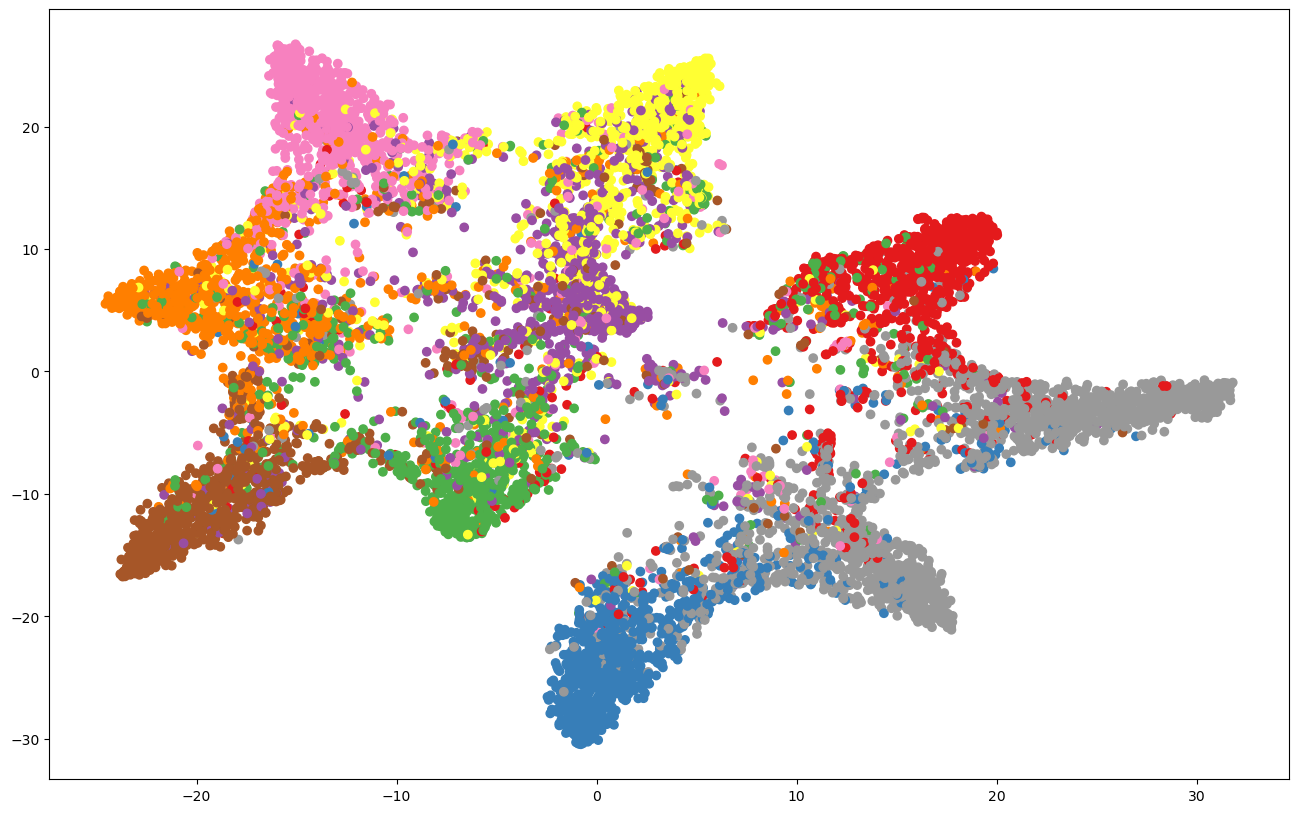

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=500)
# n_components : the number of reduced dimension.
# perplexity : (roughly) number of neighbors.
tsne_results = tsne.fit_transform(feature_arr)

plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_arr, cmap='Set1')
plt.show()

top1 acc 70점대. Not bad!

In [37]:
print("feature min max", features.min(), features.max())

feature min max tensor(0., device='cuda:0') tensor(2.2559, device='cuda:0')


# ResNet original 논문의 선택은?? 

## 2. With optimizer scheduler

In [ ]:
model = torchvision.models.resnet18(pretrained=False, num_classes=10).to(device)

epochs = 100
for epoch in range(epochs):
  top1_train_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    top1 = accuracy(logits, y_batch, topk=(1,))
    top1_train_accuracy += top1[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  top1_train_accuracy /= (counter + 1)
  top1_accuracy = 0
  top5_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
  
    top1, top5 = accuracy(logits, y_batch, topk=(1,5))
    top1_accuracy += top1[0]
    top5_accuracy += top5[0]
  
  top1_accuracy /= (counter + 1)
  top5_accuracy /= (counter + 1)
  print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")